# Model Conversion

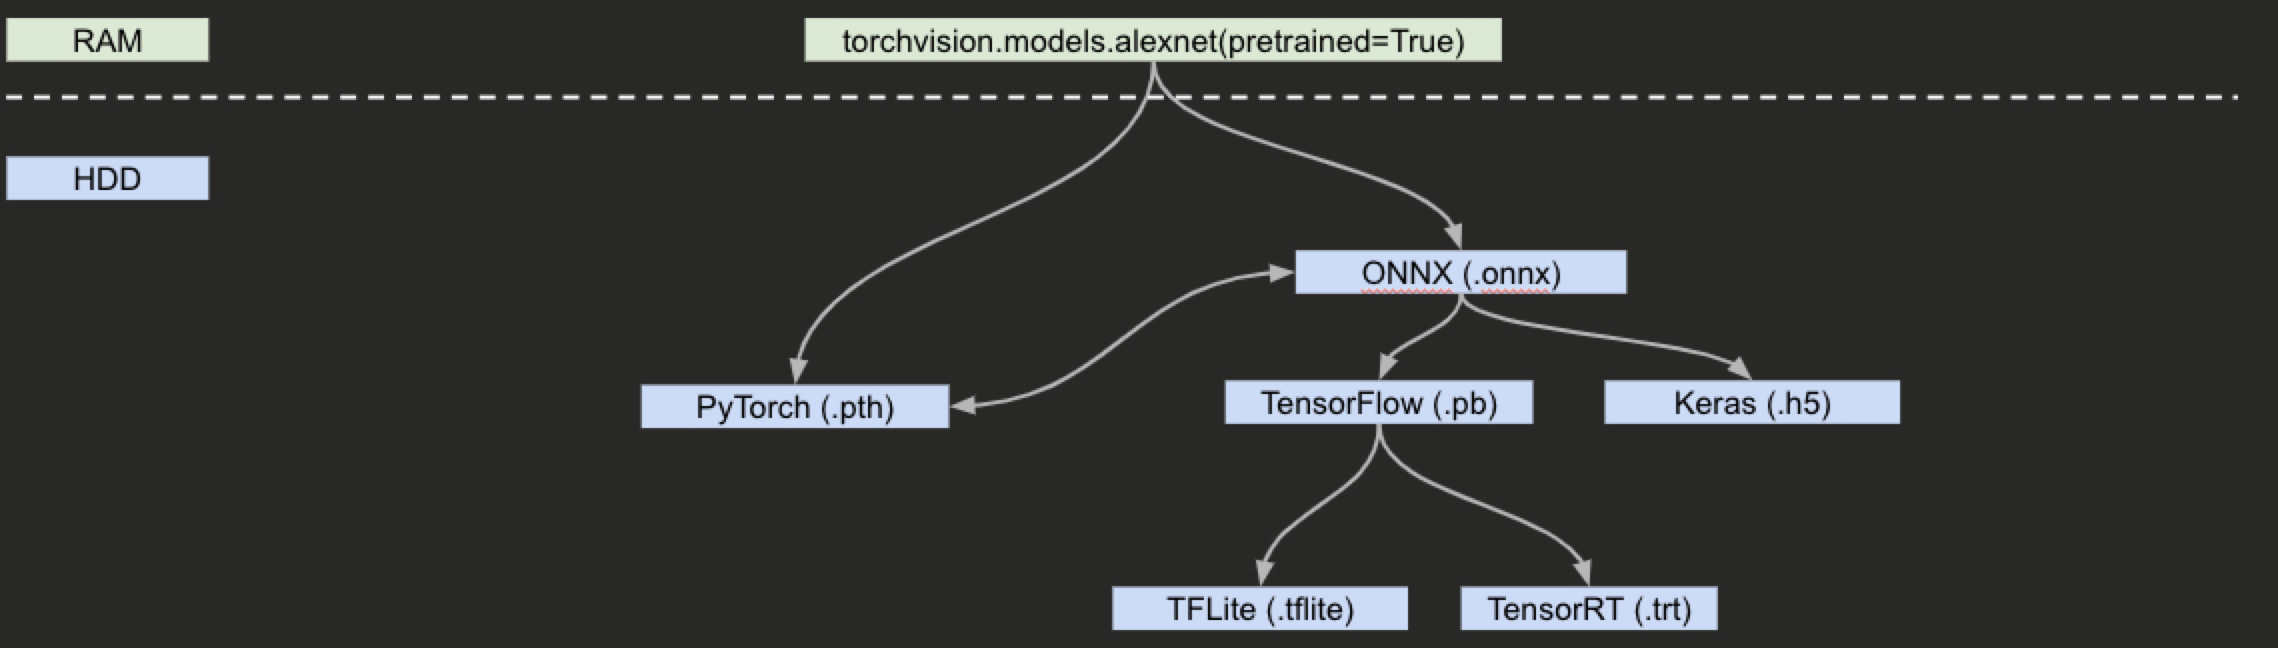

In [13]:
!pip install onnx2keras
!pip install pycuda
!pip install onnx==1.7.0
!pip install Pympler
!pip install onnx-tf==1.7.0
!pip install tensorflow-addons==0.11.2

In [14]:
import torch
import torchvision
import onnx
from onnx_tf.backend import prepare
from onnx2keras import onnx_to_keras
from onnx_tf.backend import prepare
import tensorflow as tf

In [15]:
# Check version
print(tf.__version__)
print(onnx.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.4.1
1.7.0
1.8.0+cu101
0.9.0+cu101


In [16]:
dummy_input = torch.randn(10, 3, 224, 224, device='cuda')
model = torchvision.models.alexnet(pretrained=True).cuda()

input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ] # layer 순서가 바뀌는지 확인해보기 위해 사용
output_names = [ "output1" ]

In [17]:
# export torch (.pth)
torch.save(model, "alexnet.pth")

In [18]:
# export torch -> .onnx
torch.onnx.export(model, dummy_input, "alexnet.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%actual_input_1 : Float(10, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cuda:0),
      %learned_0 : Float(64, 3, 11, 11, strides=[363, 121, 11, 1], requires_grad=1, device=cuda:0),
      %learned_1 : Float(64, strides=[1], requires_grad=1, device=cuda:0),
      %learned_2 : Float(192, 64, 5, 5, strides=[1600, 25, 5, 1], requires_grad=1, device=cuda:0),
      %learned_3 : Float(192, strides=[1], requires_grad=1, device=cuda:0),
      %learned_4 : Float(384, 192, 3, 3, strides=[1728, 9, 3, 1], requires_grad=1, device=cuda:0),
      %learned_5 : Float(384, strides=[1], requires_grad=1, device=cuda:0),
      %learned_6 : Float(256, 384, 3, 3, strides=[3456, 9, 3, 1], requires_grad=1, device=cuda:0),
      %learned_7 : Float(256, strides=[1], requires_grad=1, device=cuda:0),
      %learned_8 : Float(256, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cuda:0),
      %learned_9 : Float(256, strides=[1], requires_grad=1, device=cuda:0),
      %learn

In [19]:
# export onnx -> .pth
model = onnx.load("alexnet.onnx")
torch.save(model, "alexnet-onnx2pth.pth")

In [20]:
# export onnx -> tensorflow (.pb)
onnx_model = onnx.load("alexnet.onnx")  
output = prepare(onnx_model)
output.export_graph("alexnet.pb")

INFO:tensorflow:Assets written to: alexnet.pb/assets


INFO:tensorflow:Assets written to: alexnet.pb/assets


In [21]:
# export onnx -> keras (.h5)
onnx_model = onnx.load("alexnet.onnx")
k_model = onnx_to_keras(onnx_model, ['actual_input_1'])
k_model.save("alexnet.h5")

In [22]:
# export pb -> tensorflowlite (.tflite)
converter = tf.lite.TFLiteConverter.from_saved_model("alexnet.pb")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_model = converter.convert()
open('alexnet.tflite', 'wb').write(tf_lite_model)

61161664

In [23]:
# export pb -> tensorrt (.trt)
params = tf.experimental.tensorrt.ConversionParams(precision_mode='FP16')
converter = tf.experimental.tensorrt.Converter(input_saved_model_dir="alexnet.pb", conversion_params=params)
converter.convert()
converter.save("alexnet.trt")

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Assets written to: alexnet.trt/assets


INFO:tensorflow:Assets written to: alexnet.trt/assets
